In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
df = pd.read_csv('data/arguments-training.tsv',delimiter="\t")

<AxesSubplot: ylabel='Frequency'>

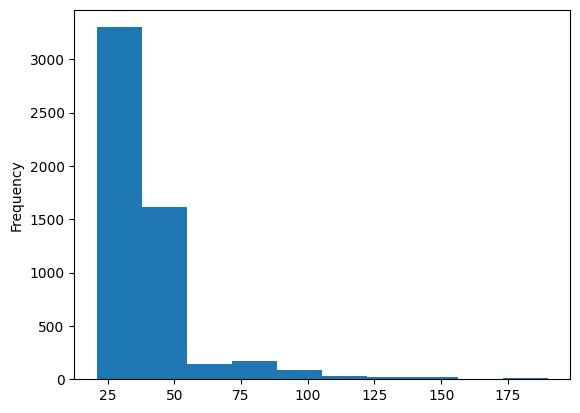

In [5]:
df['Conclusion'].str.len().plot(kind='hist')

In [13]:
np.percentile(df['Premise'].str.len(),100)

792.0

In [14]:
from transformers import AutoModel,AutoTokenizer

model = AutoModel.from_pretrained("microsoft/deberta-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [33]:
pl = df[['Premise','Conclusion','Stance']].apply(lambda x: tokenizer(x[0]+' [SEP] '+x[1]+' [SEP] '+x[2])['input_ids'],axis=1)
# np.percentile(pl,q=100)

{'input_ids': [1, 1437, 2, 1437, 0, 1437, 0, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [42]:
model()

IndexError: tuple index out of range

In [62]:
a = torch.LongTensor(tokenizer([' [SEP] [PAD] [PAD]',])['input_ids'])
print(a.shape)
a = a.repeat([2,1,])
a.shape

torch.Size([1, 8])


torch.Size([2, 8])

In [64]:
import torch.nn as nn
classifier = nn.Sequential(*[nn.Linear(768,128),
                                         nn.Linear(128,20)])

In [67]:
emb = model(a)['last_hidden_state'][:,0,:]

In [69]:
classifier(emb).shape

torch.Size([2, 20])

In [16]:
from torchmetrics import F1Score,Precision,Recall
f1 = F1Score(task="multilabel",num_labels=20)
p = Precision(task='multilabel',num_labels=20)
r = Recall(task='multilabel',num_labels=20)

In [1]:
from utils import *
from transformers import AutoModel,AutoTokenizer
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer



import torch.optim as optim

model = AutoModel.from_pretrained("microsoft/deberta-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

train_loader = DataLoader(Data(tokenizer,"training"),batch_size=16,collate_fn=collate_fn,shuffle=True,)
val_loader = DataLoader(Data(tokenizer,"validation"),batch_size=16,collate_fn=collate_fn,)


wandb_logger = WandbLogger(project="values",mode="disabled")






Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# define the LightningModule
class MLClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model=model
        self.classifier = nn.Sequential(*[nn.Linear(768,128),
                                         nn.Linear(128,20)])
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self,x):
        emb = self.model(x)['last_hidden_state'][:,0,:]
        o = self.classifier(emb)
        return o
    
    def prediction_reducer(self,otps):
        predictions = torch.cat([i['predictions'].detach() for i in otps])
        if 'labels' in otps[0]:
            labels = torch.cat([i['labels'].detach() for i in otps])
            return predictions,labels
        return predictions


    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X,y = batch
        o = self.forward(X)
        loss = self.loss_fn(o, y)
        self.log("train_loss", loss,on_step=True,on_epoch=True)
        return {"loss": loss, "predictions": o,"labels":y}


    def training_epoch_end(self, training_step_outputs):
        predictions,labels = self.prediction_reducer(training_step_outputs)
        print(predictions)
        print(labels)
        print(f1(predictions,labels))
        # print(classification_report(labels.cpu(),(predictions>0.5).cpu()))

    

    def validation_step(self, batch,batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        X,y = batch
        o = self.forward(X)
        loss = self.loss_fn(o, y)
        self.log("Validation loss", loss,on_epoch=True)
        return {"loss": loss, "predictions": o,"labels":y}

    def validation_epoch_end(self, validation_step_outputs):
        predictions,labels = self.prediction_reducer(validation_step_outputs)
        # print(classification_report(labels.cpu(),(predictions>0.5).cpu()))
    
    def predict_step(self, batch, batch_idx):
        # take average of `self.mc_iteration` iterations
        X,y = batch
        pred = self(X)
        return pred,y

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer




# init the autoencoder
clf = MLClassifier(model)


In [28]:
trainer = pl.Trainer( max_epochs=1,accelerator="gpu", devices=1,logger=wandb_logger)
trainer.fit(model=clf, train_dataloaders=train_loader,val_dataloaders = val_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | model      | DebertaModel      | 138 M 
1 | classifier | Sequential        | 101 K 
2 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
554.811   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/torchmetrics/metric.py", line 395, in wrapped_func
    f" `metric={self.__class__.__name__}(...).to(device)` where"
  File "/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/torchmetrics/classification/stat_scores.py", line 475, in update
  File "/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/torchmetrics/classification/stat_scores.py", line 74, in _update_state
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6672/744120309.py", line 2, in <cell line: 2>
    trainer.fit(model=clf, train_dataloaders=trai

In [3]:
predictions = trainer.predict(model=clf,dataloaders=train_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home2/siri.venkata/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 338it [00:00, ?it/s]

In [26]:
torch.cat([torch.rand(16,20),torch.rand(8,20)]).shape

torch.Size([24, 20])

In [ ]:
from utils import *

train_loader = DataLoader(Data(tokenizer,"training"),batch_size=16,collate_fn=collate_fn,shuffle=True,)
val_loader = DataLoader(Data(tokenizer,"validation"),batch_size=16,collate_fn=collate_fn,)
test_loader = DataLoader(Data(tokenizer,"test"),batch_size=16,collate_fn=collate_fn,)